# SNU_CVLab_baseline (MNIST)
![image](https://i.imgur.com/1yq56OL.png)

In [1]:
import os, sys, time
import numpy as np
import scipy.ndimage, scipy.misc
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
slim = tf.contrib.slim

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"



def unpickle(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
        return data

def load_cifar10_data(data_dir):
    train_data = None
    train_labels = []
    
    for i in range(1,6):
        data_dic = unpickle(data_dir + "/data_batch_{}".format(i))
        if i==1:
            train_data = data_dic['data']
        else:
            train_data = np.vstack((train_data, data_dic['data']))
        train_labels += data_dic['labels']
    test_data_dic = unpickle(data_dir + "/test_batch")
    test_data = test_data_dic['data']
    test_labels = test_data_dic['labels']
    
    train_data = train_data.reshape((len(train_data), 3, 32, 32))
    train_data = np.rollaxis(train_data, 1, 4)
    train_labels = np.array(train_labels)
    
    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = np.rollaxis(test_data, 1, 4)
    test_labels = np.array(test_labels)
    
    return train_data, train_labels, test_data, test_labels

data_dir = '/ideaHome/Dropbox/SJ/ML/Cifar10/Data/cifar-10-batches-py'
trImg, train_labels, teImg, test_labels = load_cifar10_data(data_dir)


print("Training data set : %3d, Test data Set : %3d" %(trImg.shape[0], teImg.shape[0]))

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.
Training data set : 50000, Test data Set : 10000


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def toLR(image, scale=2.):
    if len(image.shape)==4:
        num_sample = image.shape[0]
        images = np.zeros([image.shape[0], int(image.shape[1]/scale), int(image.shape[2]/scale), image.shape[3]])
        for i in range(num_sample):
            images[i,:,:,0] = scipy.misc.imresize(image[i,:,:,0], 1/scale,'bicubic')
        return images
    else:
        return scipy.misc.imresize(image, 1/scale, 'bicubic')
    

def Bicubic(image, scale=2):
    if len(image.shape)==4:
        bicImg = scipy.ndimage.interpolation.zoom(image, [1, scale, scale, 1], prefilter=False)
    else:
        bicImg = scipy.ndimage.interpolation.zoom(image, [scale,scale, 1], prefilter=False)
    return bicImg

def _phase_shift(I, r):
    # Helper function with main phase shift operation
    bsize, a, b, c = I.get_shape().as_list()
    X = tf.reshape(I, (-1, a, b, r, r))
    X = tf.transpose(X, (0, 1, 2, 4, 3))  # bsize, a, b, 1, 1
    X = tf.split(X, a, 1)  # a, [bsize, b, r, r]
    X = tf.concat([tf.squeeze(x) for x in X], axis=2)  # bsize, b, a*r, r
    X = tf.split(X, b, 1)  # b, [bsize, a*r, r]
    X = tf.concat([tf.squeeze(x) for x in X], axis=2)  # bsize, a*r, b*r
    return tf.reshape(X, (-1, a*r, b*r, 1))

def PS(X, r, color=False):
  # Main OP that you can arbitrarily use in you tensorflow code
    if color:
        Xc = tf.split(X,3,3) #(3, 3, X)
        X = tf.concat([_phase_shift(x, r) for x in Xc], axis=3)
    else:
        X = _phase_shift(X, r)
    return X

def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
    return squash_factor * unit_vector

def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [4]:
class CVLab(object):
    def __init__(self, mode):
        self.LR_dim = (28,28,1)
        self.HR_dim = (28,28,1)
        self.batch_size = 32
        self.mode = mode

        print('The model is generated')
    def RB(self, in_layer, name='default'):
        with slim.arg_scope([slim.conv2d], num_outputs=64, kernel_size=[3,3], stride=[1,1], activation_fn = tf.nn.relu, padding='SAME',
                                                   weights_initializer=tf.contrib.layers.xavier_initializer()):
            layer1 = slim.conv2d(inputs=in_layer, scope=name+'-conv1')
            layer2 = slim.conv2d(inputs=layer1, activation_fn=None, scope=name+'-conv2')
            layer3 = tf.add(layer2, in_layer, name=name+'residual')
        return layer3
        
    def model(self, img):
        name='a'
        self.conv1 = slim.conv2d(inputs=img, num_outputs=64, kernel_size=[3,3], stride=[1,1], activation_fn=None, padding='SAME',
                                weights_initializer=tf.contrib.layers.xavier_initializer())    
        
        
        
        self.RB1 = self.RB(self.conv1, 'rb1')
        self.RB2 = self.RB(self.RB1, 'rb2')
        self.RB3 = self.RB(self.RB2, 'rb3')
        self.RB4 = self.RB(self.RB3, 'rb4')
        self.RB5 = self.RB(self.RB4, 'rb5')
        self.RB6 = self.RB(self.RB5, 'rb6')
        self.RB7 = self.RB(self.RB6, 'rb7')
        self.RB8 = self.RB(self.RB7, 'rb8')
        self.RB9 = self.RB(self.RB8, 'rb9')
        self.RB10 = self.RB(self.RB9, 'rb10')
        self.RB11 = self.RB(self.RB10, 'rb11')
        self.RB12 = self.RB(self.RB11, 'rb12')
        self.RB13 = self.RB(self.RB12, 'rb13')
        self.RB14 = self.RB(self.RB13, 'rb14')
        self.RB15 = self.RB(self.RB14, 'rb15')
        self.RB16 = self.RB(self.RB15, 'rb16')
        
        with slim.arg_scope([slim.conv2d], kernel_size=[3,3], stride=[1,1], activation_fn=None, padding='SAME', 
                           weights_initializer=tf.contrib.layers.xavier_initializer()):
            self.conv2 = slim.conv2d(inputs=self.RB16, num_outputs=64)
            self.residual = tf.add(self.conv1, self.conv1)
            self.conv3 = slim.conv2d(inputs=self.residual, num_outputs=4)
        
            self.ps = PS(self.conv3, 2, False)
            self.conv4 = slim.conv2d(inputs=self.ps, num_outputs=1)
        
        out = self.conv4
        return out
    
    def loss(self, SR, HR):
        #loss = tf.losses.absolute_difference(SR, HR)
        loss =tf.reduce_mean(tf.square(SR - HR))#
        
        return loss
    
    def build(self):
        if self.mode == 'bicubic':
            self.LRImg = tf.placeholder(tf.float32, [None, 28, 28, 1], 'LRImgBicubic')
        elif self.mode == 'pixelshuffle':
            self.LRImg = tf.placeholder(tf.float32, [None, 14, 14, 1], 'LRImgPixelShuffle')
        else:
            print ('undefined mode')
        self.HRImg = tf.placeholder(tf.float32, [None, 28, 28, 1], 'HRImg')
        self.SRImg = self.model(self.LRImg)
        self.LOSS = self.loss(self.SRImg, self.HRImg)
    
    
    
    def _phase_shift(I, r):
        # Helper function with main phase shift operation
        bsize, a, b, c = I.get_shape().as_list()
        X = tf.reshape(I, (bsize, a, b, r, r))
        X = tf.transpose(X, (0, 1, 2, 4, 3))  # bsize, a, b, 1, 1
        X = tf.split(X, a, 1)  # a, [bsize, b, r, r]
        X = tf.concat([tf.squeeze(x) for x in X], asix=2)  # bsize, b, a*r, r
        X = tf.split(X, b, 1)  # b, [bsize, a*r, r]
        X = tf.concat([tf.squeeze(x) for x in X], axis=2)  # bsize, a*r, b*r
        return tf.reshape(X, (bsize, a*r, b*r, 1))

    def PS(X, r, color=False):
      # Main OP that you can arbitrarily use in you tensorflow code
        if color:
            Xc = tf.split(X,3,3) #(3, 3, X)
            X = tf.concat([_phase_shift(x, r) for x in Xc], axis=3)
        else:
            X = _phase_shift(X, r)
        return X

In [5]:
tf.reset_default_graph()
model = CVLab('pixelshuffle')
model.build()

t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The model is generated
---------
Variables: name (type shape) [size]
---------
Conv/weights:0 (float32_ref 3x3x1x64) [576, bytes: 2304]
Conv/biases:0 (float32_ref 64) [64, bytes: 256]
rb1-conv1/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb1-conv1/biases:0 (float32_ref 64) [64, bytes: 256]
rb1-conv2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb1-conv2/biases:0 (float32_ref 64) [64, bytes: 256]
rb2-conv1/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb2-conv1/biases:0 (float32_ref 64) [64, bytes: 256]
rb2-conv2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb2-conv2/biases:0 (float32_ref 64) [64, bytes: 256]
rb3-conv1/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb3-conv1/biases:0 (float32_ref 64) [64, bytes: 256]
rb3-conv2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb3-conv2/biases:0 (float32_ref 64) [64, bytes: 256]
rb4-conv1/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
rb4-conv1/biases:0 (float32_r

(1221582, 4886328)

In [6]:
learning_rate=tf.placeholder(tf.float32, shape=[])
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(model.LOSS)

In [7]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 
sess.run(tf.global_variables_initializer())

In [8]:
saver=tf.train.Saver()
#saver.restore(sess, 'checkpoints/SRCNN/MNIST_psnr_21-09')

In [9]:
batch_size=8
total_iter = int(trImg.shape[0]/batch_size)-1
lr=1e-4
for epoch in range(500):
    avg_psnr = 0
    cnt=0
    start_time = time.time()
    for batch in range(total_iter):
        trImg, _= mnist.train.next_batch(batch_size)
        trImg = np.reshape(trImg, [-1, 28, 28, 1])
        LRImg = toLR(trImg)-0.11
        HRImg = trImg - 0.11
        cnt+=1
        
        _, loss = sess.run([optm, model.LOSS], feed_dict={model.LRImg:LRImg, model.HRImg: HRImg, learning_rate:lr})
        psnr = 20*np.log10(1./np.sqrt(loss))
        print ("\rbatch: {}/{} ({:.1f}%) psnr: {:.5f}".format(batch, total_iter, batch*100/total_iter, psnr), end="")
        avg_psnr+=psnr
    if epoch%2==0:
        lr*=0.5
    print ('\repoch: %3d, avg_PSNR: %4f, time for epoch: %.2f' %(epoch, avg_psnr/(cnt+1e-8), time.time()-start_time))

/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


epoch:   0, avg_PSNR: 8.729271, time for epoch: 34.36
epoch:   1, avg_PSNR: 17.951242, time for epoch: 33.88
epoch:   2, avg_PSNR: 19.512859, time for epoch: 33.79
epoch:   3, avg_PSNR: 20.321439, time for epoch: 33.76
epoch:   4, avg_PSNR: 20.645167, time for epoch: 33.64
epoch:   5, avg_PSNR: 20.879574, time for epoch: 33.69
epoch:   6, avg_PSNR: 20.962673, time for epoch: 33.78
epoch:   7, avg_PSNR: 21.042132, time for epoch: 33.68
epoch:   8, avg_PSNR: 21.063483, time for epoch: 33.71
epoch:   9, avg_PSNR: 21.096282, time for epoch: 33.67
epoch:  10, avg_PSNR: 21.108185, time for epoch: 33.58
epoch:  11, avg_PSNR: 21.123264, time for epoch: 33.80
epoch:  12, avg_PSNR: 21.130716, time for epoch: 33.92
epoch:  13, avg_PSNR: 21.139215, time for epoch: 33.81
epoch:  14, avg_PSNR: 21.130944, time for epoch: 33.82
epoch:  15, avg_PSNR: 21.147092, time for epoch: 33.91
epoch:  16, avg_PSNR: 21.144146, time for epoch: 33.85
epoch:  17, avg_PSNR: 21.146582, time for epoch: 33.89
epoch:  18,

KeyboardInterrupt: 

/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


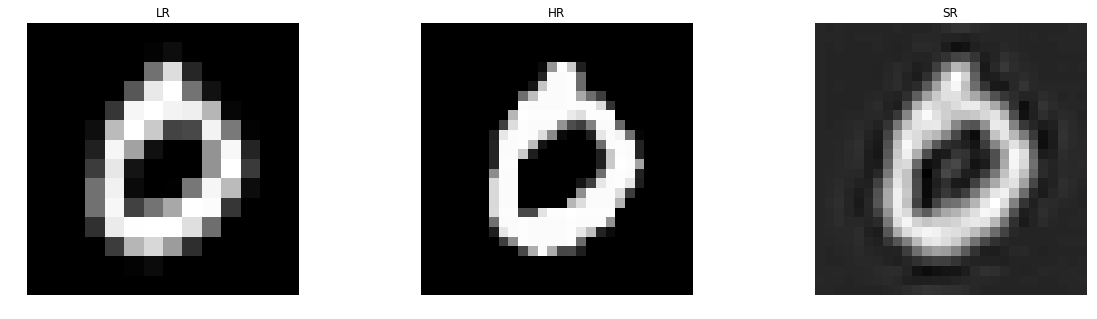

In [14]:
showimg = mnist.test.images[0:32,:]-0.11
hrimg = np.reshape(showimg, [-1, 28, 28, 1])
lrimg = toLR(hrimg)
srimg=sess.run(model.conv4, feed_dict={model.LRImg:lrimg})
index=3

plt.figure(figsize=[20,5])
plt.subplot(1,3,1)
plt.axis('off')
plt.title('LR')
plt.imshow(lrimg[index,:,:,0], cmap='gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.title('HR')
plt.imshow(hrimg[index,:,:,0], cmap='gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.title('SR')
plt.imshow(srimg[index,:,:,0], cmap='gray')


In [13]:
showimg = mnist.test.images[0:32,:]
hrimg = np.reshape(showimg, [-1, 28, 28, 1])
lrimg = toLR(hrimg)
srimg=sess.run(model.out_layer, feed_dict={model.LRImg:lrimg})
index=3

plt.figure(figsize=[20,5])
plt.subplot(1,3,1)
plt.axis('off')
plt.title('LR')
plt.imshow(lrimg[index,:,:,0], cmap='gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.title('HR')
plt.imshow(hrimg[index,:,:,0], cmap='gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.title('SR')
plt.imshow(srimg[index,:,:,0], cmap='gray')


/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


AttributeError: 'CVLab' object has no attribute 'out_layer'

In [16]:
saver = tf.train.Saver()
saver.save(sess, 'checkpoints/SRCNN/MNIST_psnr_21-09')

'checkpoints/SRCNN/MNIST_psnr_21-09'

In [17]:
sess.run(tf.global_variables_initializer())

In [ ]:
with slim.arg_scope([slim.conv2d], num_outputs=64, kernel_size=[5,5], stride=[1,1], activation_fn = tf.nn.relu, padding='SAME',
                                                   weights_initializer=tf.contrib.layers.xavier_initializer()):
            self.layer1 = slim.conv2d(inputs=self.conv1, scope='1conv1')
            self.layer2 = slim.conv2d(inputs=self.layer1, activation_fn=None, scope=name+'1conv2')
            self.layer3 = tf.add(self.layer2, self.conv1, name=name+'1residual')
            
            self.layer21 = slim.conv2d(inputs=self.layer3, scope='2convtg1')
            self.layer22 = slim.conv2d(inputs=self.layer21, activation_fn=None, scope=name+'2conv2')
            self.layer23 = tf.add(self.layer22, self.layer3, name=name+'2residual')
        
            self.layer31 = slim.conv2d(inputs=self.layer23, scope='32conv1')
            self.layer32 = slim.conv2d(inputs=self.layer31, activation_fn=None, scope=name+'32conv2')
            self.layer33 = tf.add(self.layer32, self.layer23, name=name+'32residual')
            
            self.layer41 = slim.conv2d(inputs=self.layer33, scope='42conv1')
            self.layer42 = slim.conv2d(inputs=self.layer41, activation_fn=None, scope=name+'42conv2')
            self.layer43 = tf.add(self.layer42, self.layer33, name=name+'42residual')
            
            self.layer51 = slim.conv2d(inputs=self.layer43, scope='52conv1')
            self.layer52 = slim.conv2d(inputs=self.layer51, activation_fn=None, scope=name+'52conv2')
            self.layer53 = tf.add(self.layer52, self.layer43, name=name+'52residual')
            
            self.layer61 = slim.conv2d(inputs=self.layer53, scope='62conv1')
            self.layer62 = slim.conv2d(inputs=self.layer61, activation_fn=None, scope=name+'62conv2')
            self.layer63 = tf.add(self.layer62, self.layer53, name=name+'62residual')
            
            self.layer71 = slim.conv2d(inputs=self.layer63, scope='72conv1')
            self.layer72 = slim.conv2d(inputs=self.layer71, activation_fn=None, scope=name+'72conv2')
            self.layer73 = tf.add(self.layer72, self.layer63, name=name+'72residual')
            
            self.layer81 = slim.conv2d(inputs=self.layer73, scope='82conv1')
            self.layer82 = slim.conv2d(inputs=self.layer81, activation_fn=None, scope=name+'82conv2')
            self.layer83 = tf.add(self.layer82, self.layer73, name=name+'82residual')
            
            self.layer91 = slim.conv2d(inputs=self.layer83, scope='92conv1')
            self.layer92 = slim.conv2d(inputs=self.layer91, activation_fn=None, scope=name+'92conv2')
            self.layer93 = tf.add(self.layer92, self.layer83, name=name+'92residual')
            
            self.layer101 = slim.conv2d(inputs=self.layer93, scope='102conv1')
            self.layer102 = slim.conv2d(inputs=self.layer101, activation_fn=None, scope=name+'102conv2')
            self.layer103 = tf.add(self.layer102, self.layer93, name=name+'102residual')
            
            self.layer111 = slim.conv2d(inputs=self.layer103, scope='112conv1')
            self.layer112 = slim.conv2d(inputs=self.layer111, activation_fn=None, scope=name+'112conv2')
            self.layer113 = tf.add(self.layer112, self.layer103, name=name+'112residual')
            
            self.layer121 = slim.conv2d(inputs=self.layer113, scope='122conv1')
            self.layer122 = slim.conv2d(inputs=self.layer121, activation_fn=None, scope=name+'122conv2')
            self.layer123 = tf.add(self.layer122, self.layer113, name=name+'212residual')
            
            self.layer131 = slim.conv2d(inputs=self.layer123, scope='132conv1')
            self.layer132 = slim.conv2d(inputs=self.layer131, activation_fn=None, scope=name+'132conv2')
            self.layer133 = tf.add(self.layer132, self.layer123, name=name+'132residual')
            
            self.layer141 = slim.conv2d(inputs=self.layer133, scope='2conv1')
            self.layer142 = slim.conv2d(inputs=self.layer141, activation_fn=None, scope=name+'142conv2')
            self.layer143 = tf.add(self.layer142, self.layer133, name=name+'142residual')
            
            self.layer151 = slim.conv2d(inputs=self.layer143, scope='152conv1')
            self.layer152 = slim.conv2d(inputs=self.layer151, activation_fn=None, scope=name+'152conv2')
            self.layer153 = tf.add(self.layer152, self.layer143, name=name+'152residual')
            
            self.layer161 = slim.conv2d(inputs=self.layer153, scope='162conv1')
            self.layer162 = slim.conv2d(inputs=self.layer161, activation_fn=None, scope=name+'162conv2')
            self.layer163 = tf.add(self.layer162, self.layer153, name=name+'216residual')